In [59]:
############################get packages and define functions#################
from obspy import read
import obspy
import obspy.signal.filter
import obspy.signal.invsim
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates 
from scipy import optimize as op
from scipy import signal
import re
from obspy import Trace, Stream
from obspy.core import UTCDateTime
import obspy.signal.freqattributes
from os import path
import glob
import matplotlib.colors as colors
from functions_mc import read_sim_header, read_sim#, read_sec, read_trc
read_sec = 0
read_trc = 0
read_header = read_sim_header

def position(Number): 
    r = re.compile("([a-zA-Z]+)([0-9]+)")
    m = r.match(Number)
    num = int(m.group(2)) 
    with open('./update_models/Sensor_coordinates.txt') as f:
        lines = f.readlines()
    line = lines[num-119]
    line =line.replace("  "," ")
    line =line.replace("  "," ")
    line =line.replace("  "," ")
    y = int(line.split(' ')[5])
    x = int(line.split(' ')[4])
    return x,y

class mc_sim():
    def __init__(self,filename):
        """Read and analyze MC simulation.
        """
        # extract first part of filename without file extension
        self.sim_base_name = path.split(filename)[1][:-4]
        # path of the simulation folder
        self.sim_path = path.split(filename)[0]
        # read simulation header
        self.head = read_sim_header(filename)
        reading = {0:{'extension':'sim',
                      'read_func':read_sim},
                   1:{'extension':'sec',
                      'read_func':read_sec},
                   2:{'extension':'trc',
                      'read_func':read_trc}
                  }
        opt = self.head['outputtype']
        files = glob.glob(path.join(self.sim_path,
                                    self.sim_base_name+'*.%s' 
                                    % reading[opt]['extension']))
        self.data = {}
        for fname in files:
            # recording type encoded in filename between last underscore
            # and the file extension
            rec_type = fname.split('_')[-1].split('.')[0]
            data, axes = reading[opt]['read_func'](fname,self.head)
            if hasattr(self,'axes'):
                assert axes.keys() == self.axes.keys(), 'Axes of different recording types'\
                                          'must be identical'
                for key in axes.keys():
                    assert np.all(axes[key] == self.axes[key]), 'Axes of different recording types'\
                                          'must be identical'
            else:
                self.axes = axes
            self.data.update({rec_type:data})
            
def local_energy_density(x,y,z,mc,rec_type):
    lenth = 0
    ar = np.arange(-lenth,1+lenth,1)
    s_ar = mc.head['GridSpacing'][0] * mc.head['GridSpacing'][1] 
    x_ind = np.argmin(np.abs(mc.axes['x']-x))
    y_ind = np.argmin(np.abs(mc.axes['y']-y))
    z_ind = np.argmin(np.abs(mc.axes['z']-z))
#       time_ind=(mc.axes['t']*10).astype(int)
    x_ar = ar+ x_ind
    x_ar = [n for n in x_ar if n > 0 and n <len(mc.axes['x'])-1]
    y_ar = ar+ y_ind
    y_ar = [n for n in y_ar if n > 0 and n <len(mc.axes['y'])-1]
    data_ini=mc.data[rec_type][:,:,z_ind,:]
    data_sed = data_ini[x_ar,:,:]
    data_thi = data_sed[:,y_ar,:]
    #data = (np.mean(np.mean(data_thi,0),0)/s_ar)/mc.head['npart']
    data = np.sum(np.mean(np.mean(data_thi,0),0),0)/s_ar/mc.head['npart']/mc.head['emodulo']/10
    #data = np.mean(np.mean(np.mean(data_thi,0),0),0)/s_ar
    return data,x_ind,y_ind

import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

def get_axis_limits(ax, scale_x=.0, scale_y=.8):
    return ax.get_xlim()[1]*scale_x, ax.get_ylim()[1]*scale_y

def gauss_dis(x0,y0,x,y,sigma1,sigma2):
        dis_sq=np.power(x-x0,2)/np.power(sigma1,2)+np.power(y-y0,2)/np.power(sigma2,2)
        gaus= np.power(np.e,(-1*np.sqrt(dis_sq/2)))
        return (gaus)

# Show the setup of the transdusers

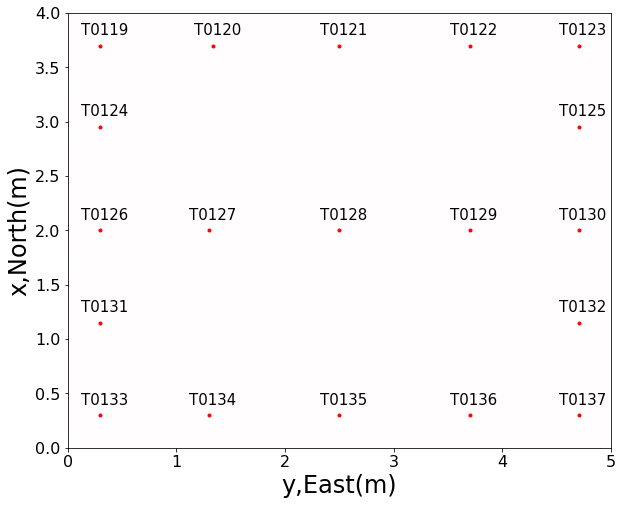

In [26]:
####################show the setup of the transdusers#################
fig, axs = plt.subplots(1,1,figsize=(10, 8))
for i in np.arange(19):
    EMB = 'T0'+str(i+119) 
    plt.scatter(position(EMB)[1]/1000,position(EMB)[0]/1000,c = 'r',marker = '.')
    axs.annotate(EMB, (position(EMB)[1]/1000-0.18,position(EMB)[0]/1000+0.1),fontsize= 15)    
axs = plt.imshow(np.zeros((500,400)), extent=[0,5,0,4],aspect=1., origin='lower',cmap='seismic',vmax=0.1, vmin=-0.1)
plt.ylabel('x,North(m)',fontsize= 24)
plt.xlabel('y,East(m)',fontsize= 24)     
plt.tick_params(axis='both', labelsize=16)

# read the processed data from the the concrete experiment

trace.stats.network: name of the source sensor<br>
trace.stats.station: name of the receiver sensor

In [27]:
path_data = '../experiment_data/processed_data/'
processed_D = []
processed_S = []
for source in np.arange(19):
    for station in np.arange(19):
        if source != station:
            tr_d = read(path_data+"envelope_"+'Src'+str(int(source+119))+'_'+'Sta'+str(int(station+119)) + ".sac")  
            tr_s = read(path_data+"wavelet_"+'Src'+str(int(source+119))+'_'+'Sta'+str(int(station+119)) + ".sac")  
            processed_D.append(tr_d[0])
            processed_S.append(tr_s[0])
##################################
Source_data = np.zeros(len(processed_S[0].data))
for i in np.arange(len(processed_S)):
    Source_data = Source_data + processed_S[i].data
Source_data = Source_data/len(processed_S)
Source_data = Source_data/np.max(Source_data)

# Check the model of 1/Q for curent iteraion 

The model of iteraion 0 exists. Copy this model into the inversion folder.


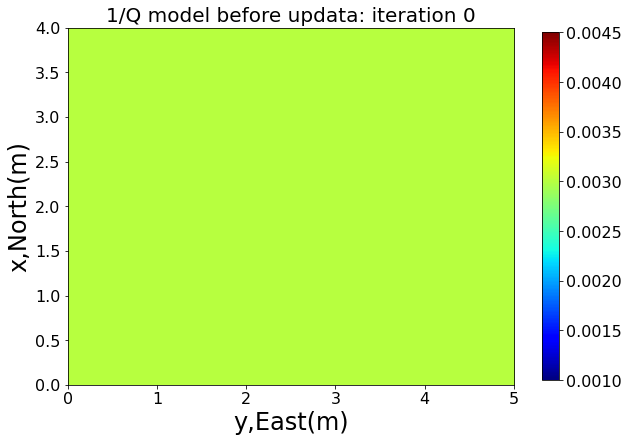

In [28]:
iteration = 0 #start form 0

########################################
plot_ = False
for i in np.arange(iteration,-1,-1):
    model_simu = '../example_for_simulation/models/Qp_model_iteration_'+str(i)+'.bin'
    if not os.path.exists(model_simu):
        print('There is no model for the iteraion %s, please go back to the iteration %s.'%(i,i-1))
    else:
        plot_ = True
        print('The model of iteraion %s exists. Copy this model into the inversion folder.'%(i))
        shutil.copy2(model_simu, 'update_models/Qp_model_iteration_'+str(i)+'_sim.bin')
        Model_Q  = np.fromfile('update_models/Qp_model_iteration_'+str(i)+'_sim.bin')
        break
if plot_ == True:
    fig, axs = plt.subplots(1,1,figsize=(10, 8))
    im = axs.imshow(np.reshape(Model_Q,(100,125)), extent=[0,5,0,4],aspect=1., origin='lower',cmap='jet',vmax=0.0045, vmin=0.001)
    plt.title('1/Q model before updata: iteration %s'%i,fontsize= 20)
    plt.ylabel('x,North(m)',fontsize= 24)
    plt.xlabel('y,East(m)',fontsize= 24)     
    plt.tick_params(axis='both', labelsize=16)
    cbar=plt.colorbar(im,ax=axs,shrink=0.8)
    cbar.ax.tick_params(labelsize=16) 

# Create the folder for this iteration 

In [5]:
dir_iter = './kernel_data/iteration_'+ str(iteration)
if not os.path.exists(dir_iter):
    os.makedirs(dir_iter)

# Chose two transdusers' combination for inversion 

In [47]:
Source = 120
Receiver = 121

# Check if there is the simulation data for this combination 
if not, stop here and go to simulation folder for simulation<br>
if yes, continue and load the simulation data

In [49]:
dir_sim = '../example_for_simulation/simu_data/iteration_'+ str(iteration)
simu_data_src = dir_sim + '/location_'+ str(Source)+'/sims/Acoustic_forward_with_boundary_iter_*.hed'
simu_data_sta = dir_sim + '/location_'+ str(Receiver)+'/sims/Acoustic_forward_with_boundary_iter_*.hed'
try:
    sim_T_1 = mc_sim(simu_data_src)
    print('The simulation data loads successfully for forward simulation %s.'%Source)
except:
    print('There is no simulation for transducer %s. Stop here and go to simulation folder for simulation'%Source)
try:
    sim_T_2 = mc_sim(simu_data_sta)
    print('The simulation data loads successfully for backward simulation %s.'%Receiver)
except:
    print('There is no simulation for transducer %s. Stop here and go to simulation folder for simulation'%Receiver)

The simulation data loads successfully for forward simulation 120.
The simulation data loads successfully for backward simulation 121.


# calculate the kernel (It takes dozens of minutes)

In [50]:
#########################time window for inversion

time_win_left = 3.5
time_win_right = 4.7

##########################
start=datetime.now()
SampFreq =  2e6
dt = 1 /SampFreq *1000 #ms
NumSamp=  10000
t_real = np.arange(0,processed_D[0].stats.delta*processed_D[0].stats.npts,processed_D[0].stats.delta)*1000 #ms
if Source != Receiver:
    #######################real data #############################
    for i in np.arange(len(processed_D)):
        if processed_D[i].stats.network == 'T0'+str(int(Source)) and processed_D[i].stats.station == 'R0'+str(int(Receiver)):
            real_data = processed_D[i].data
    #######################simulation############################
    E0 = 12 * 16
    Source_1 = 'T0'+str(int(Source))
    Station_1 = 'R0'+str(int(Receiver))
    ##################forward modeling####################
    window_nor = Source_data[::int(sim_T_1.head['GridSpacing'][4]/dt)]
    x1= position('T0'+str(int(Receiver)))[0]/1000
    y1= position('T0'+str(int(Receiver)))[1]/1000
    ###################
    y_simu_1 = local_energy_density(x1,y1,0,sim_T_1,'P')[0]
    y_simu_1 = signal.convolve(y_simu_1, window_nor)[0:len(y_simu_1)]
    y_simu_1 = y_simu_1 * E0 
    #####################resample
    real_data_resample = real_data[::int(sim_T_1.head['GridSpacing'][4]/dt)]
    ##################
    t_syn=sim_T_1.axes['t']
    #################start inversion###############
    velocity = 4.475
    distance = (position(Source_1)[0]-position(Station_1)[0])**2+ (position(Source_1)[1]-position(Station_1)[1])**2
    distance = np.sqrt(distance)/1000
    t_a = distance/velocity+0.123
    #####################calculate adjoint source#################
    time_ind_left = np.argmin(np.abs(sim_T_1.axes['t']-time_win_left))
    time_ind_right = np.argmin(np.abs(sim_T_1.axes['t']-time_win_right))
    time = sim_T_1.axes['t'][time_ind_left:time_ind_right+1]  
    diff = y_simu_1[time_ind_left:time_ind_right+1] - real_data_resample[time_ind_left:time_ind_right+1]
    adjoint_sour = np.zeros(sim_T_1.head['GridSize'][4])
    adjoint_sour[time_ind_left:time_ind_right+1] = diff[::] 
    #####################calculate adjoint wavefield################
    adjoint_sour_real = adjoint_sour[::-1]
    adjoint_wavefield = np.zeros((sim_T_1.head['GridSize'][0],sim_T_1.head['GridSize'][1],sim_T_1.head['GridSize'][3],sim_T_1.head['GridSize'][4]))   
    for t_in_real in sim_T_1.axes['t']:
        t_int = np.argmin(np.abs(sim_T_1.axes['t']-t_in_real))
        adjoint_wavefield[:,:,:,t_int]= np.sum(sim_T_2.data['P'][:,:,0,:,t_int::-1]*adjoint_sour_real[:t_int+1],3)
    ##################calculate scattering parameter###################
    vp= 4475 #m/s
    omg = 2*np.pi*60e3 #s^-1
    dn = sim_T_1.head['GridSpacing'][3]*np.pi/180
    dt_syn = sim_T_1.head['GridSpacing'][4]
    darea= sim_T_1.head['GridSpacing'][0]*sim_T_1.head['GridSpacing'][1]
    the_cal = sim_T_1.axes['theta']/180*np.pi
    lp= omg/vp# m^-1
    a = 0.011 #m
    eps = 1
    m0 = 2 * lp * np.sin(the_cal/2)
    psdf0 = 2*np.pi*np.power(eps,2)*np.power(a,2)/np.power((1 + a*a*m0*m0),1.5)
    gpp = np.power(lp,3)*psdf0
    fpp = gpp/np.sum(gpp) 
    gpp0=np.sum(gpp)*dn/(2*np.pi) #scattering mean free path
    #######################calculate kernel##############################
    kernel = np.zeros((sim_T_1.head['GridSize'][0],sim_T_1.head['GridSize'][1]))
    kernel_absorp = np.zeros((sim_T_1.head['GridSize'][0],sim_T_1.head['GridSize'][1]))

    rot = np.argmin(np.abs(sim_T_1.axes['theta']-0)) - np.argmin(np.abs(sim_T_1.axes['theta']-180))
    adjoint_wavefield_reverse = np.roll(adjoint_wavefield[:,:,:,::-1],rot,axis=2)/dn

    forward_in = np.zeros((sim_T_1.head['GridSize'][0],sim_T_1.head['GridSize'][1],sim_T_1.head['GridSize'][3],sim_T_1.head['GridSize'][4]))       

    for rot_ind in np.arange(sim_T_1.head['GridSize'][3]):
        forward_in[:,:,rot_ind,:] = np.sum(np.tile(np.roll(fpp,rot_ind),(sim_T_1.head['GridSize'][4],1)).T * sim_T_1.data['P'][:,:,0,:,:],2)                            

    kernel[:,:]=  2*np.pi*vp*(gpp0/np.power(eps,2))*np.sum(np.sum(adjoint_wavefield_reverse*(forward_in[:,:,:,:]-sim_T_1.data['P'][:,:,0,:,:]),2),2)*dn*dt_syn                                                                        
    kernel = kernel/sim_T_1.head['emodulo']/sim_T_1.head['npart']/darea/10
    kernel = kernel/sim_T_1.head['emodulo']/sim_T_1.head['npart']/darea/10

    kernel_absorp[:,:]=  -2*np.pi* omg * np.sum(np.sum(adjoint_wavefield_reverse*(sim_T_1.data['P'][:,:,0,:,:]),2),2)*dn*dt_syn                                                                     
    kernel_absorp = kernel_absorp/sim_T_1.head['emodulo']/sim_T_1.head['npart']/darea/10
    kernel_absorp = kernel_absorp/sim_T_1.head['emodulo']/sim_T_1.head['npart']/darea/10

    np.save(dir_iter+'/Kernel_result_absorbtion_'+str(Source)+'_'+str(Receiver), kernel_absorp)
    np.save(dir_iter+'/Kernel_result_scattering_'+str(Source)+'_'+str(Receiver), kernel)
end =datetime.now()
print(end-start)

0:25:27.281778


# plot the traces

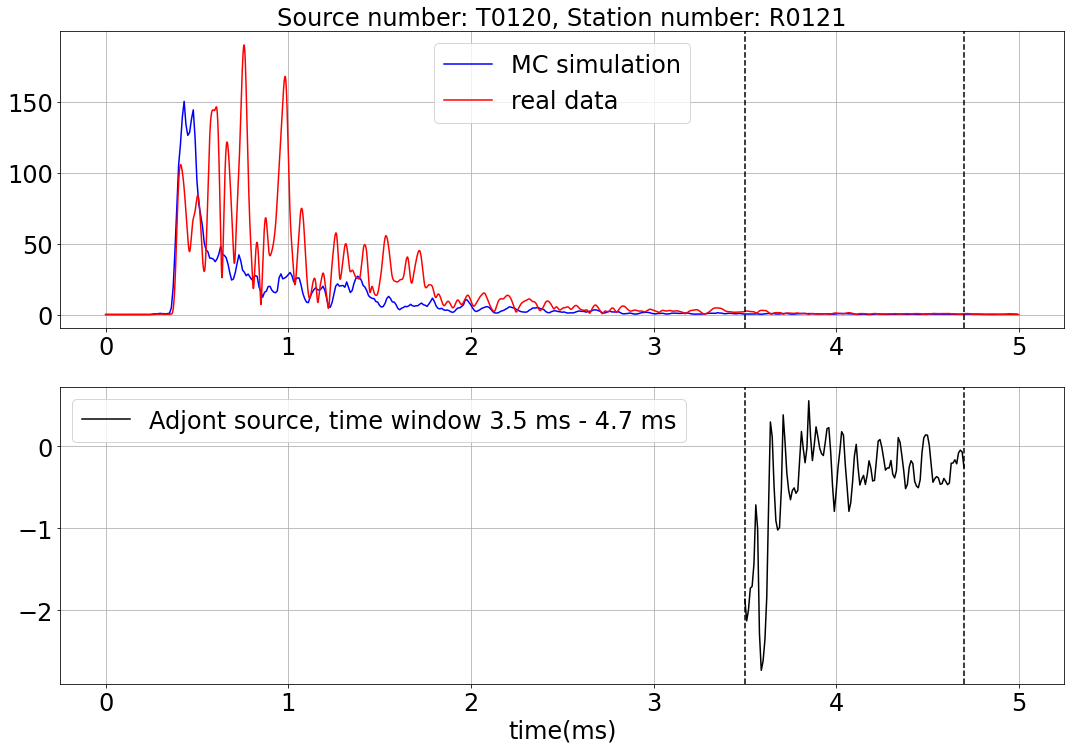

In [68]:
fig,ax = plt.subplots(2,1,figsize=(18, 12))
ax[0].set_title('Source number: %s, Station number: %s'%(Source_1,Station_1), size=24)
ax[0].plot(t_syn,y_simu_1,'-b',label = 'MC simulation')
ax[0].plot(t_real,real_data,'-r',label = 'real data')
ax[1].plot(t_syn[time_ind_left:time_ind_right+1],diff,'-k',label = 'Adjont source, time window %s ms - %s ms'%(time_win_left,time_win_right))
plt.setp(ax, xlim=ax[0].get_xlim())
ax[1].set_xlabel('time(ms)',fontsize=24)
for i in np.arange(2):
    ax[i].axvline(x=time_win_left,color='k', linestyle='--')
    ax[i].axvline(x=time_win_right,color='k', linestyle='--')
    ax[i].tick_params(axis='both', labelsize=24)
    ax[i].legend(prop={'size': 24},loc = 0)
    ax[i].grid()

# plot origianl result of the kernels

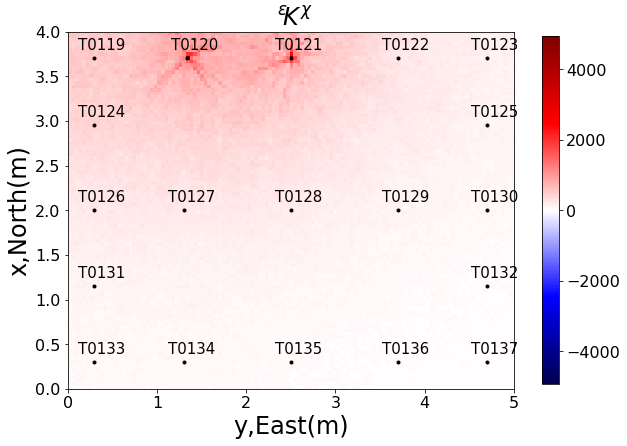

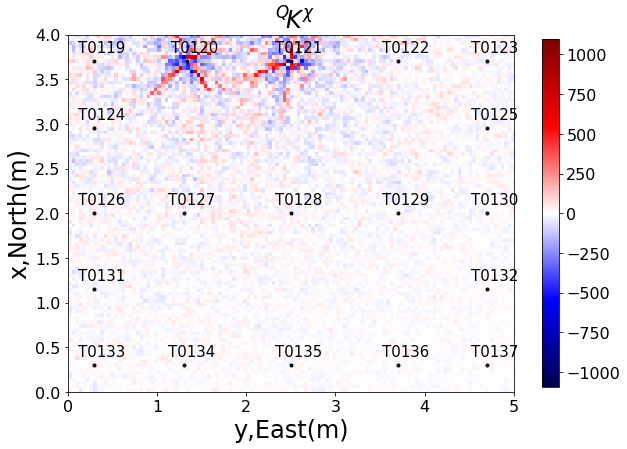

In [58]:
kernel_scatter_read = np.load(dir_iter+'/Kernel_result_absorbtion_'+str(Source)+'_'+str(Receiver)+'.npy')
kernel_absorp_read  = np.load(dir_iter+'/Kernel_result_scattering_'+str(Source)+'_'+str(Receiver)+'.npy')

fig, axs = plt.subplots(1,1,figsize=(10, 8))
for i in np.arange(19):
    EMB = 'T0'+str(i+119) 
    plt.scatter(position(EMB)[1]/1000,position(EMB)[0]/1000,c = 'k',marker = '.')
    axs.annotate(EMB, (position(EMB)[1]/1000-0.18,position(EMB)[0]/1000+0.1),fontsize= 15)    
im = plt.imshow(kernel_scatter_read, extent=[0,5,0,4],aspect=1., origin='lower',cmap='seismic',vmax=np.max(abs(kernel_scatter_read)), vmin=-np.max(abs(kernel_scatter_read)))
plt.title(r'$~^\varepsilon\!K^{\chi}$',fontsize= 24)
plt.ylabel('x,North(m)',fontsize= 24)
plt.xlabel('y,East(m)',fontsize= 24)  
plt.tick_params(axis='both', labelsize=16)
cbar=plt.colorbar(im,ax=axs,shrink=0.8)
cbar.ax.tick_params(labelsize=16)

fig, axs = plt.subplots(1,1,figsize=(10, 8))
for i in np.arange(19):
    EMB = 'T0'+str(i+119) 
    plt.scatter(position(EMB)[1]/1000,position(EMB)[0]/1000,c = 'k',marker = '.')
    axs.annotate(EMB, (position(EMB)[1]/1000-0.18,position(EMB)[0]/1000+0.1),fontsize= 15)    
im = plt.imshow(kernel_absorp_read, extent=[0,5,0,4],aspect=1., origin='lower',cmap='seismic',vmax=np.max(abs(kernel_absorp_read)), vmin=-np.max(abs(kernel_absorp_read)))
plt.ylabel('x,North(m)',fontsize= 24)
plt.xlabel('y,East(m)',fontsize= 24) 
plt.title(r'$~^Q\!K^{\chi}$',fontsize= 24)
plt.tick_params(axis='both', labelsize=16)
cbar=plt.colorbar(im,ax=axs,shrink=0.8)
cbar.ax.tick_params(labelsize=16)

# remove the singularity

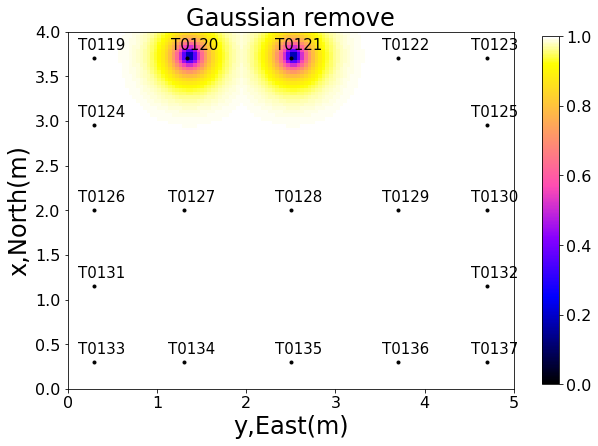

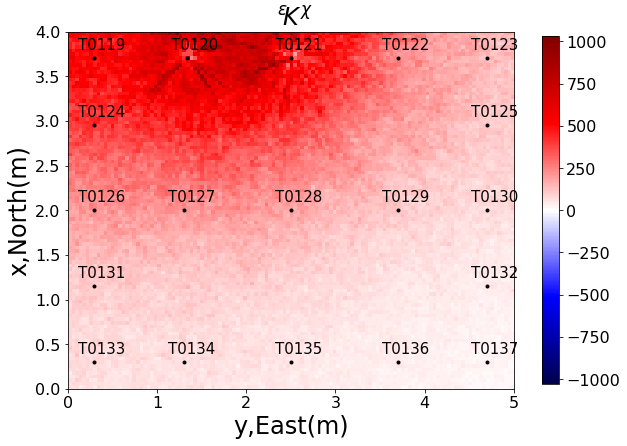

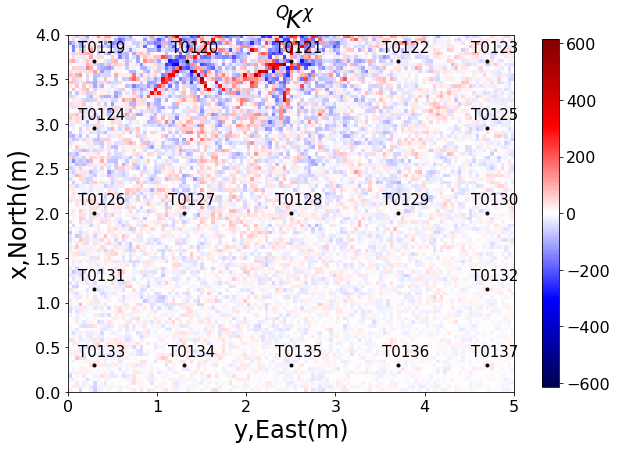

In [62]:
seta = 0.1
inv_gaus_distri = 1 + np.zeros((sim_T_1.head['GridSize'][0],sim_T_1.head['GridSize'][1]))
x1= position('T0'+str(int(Receiver)))[0]/1000
y1= position('T0'+str(int(Receiver)))[1]/1000
x2= position('T0'+str(int(Source)))[0]/1000
y2= position('T0'+str(int(Source)))[1]/1000
for i in np.arange(sim_T_1.head['GridSize'][0]):
    for j in np.arange(sim_T_1.head['GridSize'][1]):
        x = i*sim_T_1.head['GridSpacing'][0]  
        y = j*sim_T_1.head['GridSpacing'][1]  
        gaus_rece = 1- gauss_dis(x1,y1,x,y,seta,seta)
        gaus_sour = 1- gauss_dis(x2,y2,x,y,seta,seta)
        inv_gaus_distri[i][j] = min(gaus_rece,gaus_sour)

remove_ker_eps= kernel_scatter_read *inv_gaus_distri
remove_ker_Q = kernel_absorp_read * inv_gaus_distri

fig, axs = plt.subplots(1,1,figsize=(10, 8))
for i in np.arange(19):
    EMB = 'T0'+str(i+119) 
    plt.scatter(position(EMB)[1]/1000,position(EMB)[0]/1000,c = 'k',marker = '.')
    axs.annotate(EMB, (position(EMB)[1]/1000-0.18,position(EMB)[0]/1000+0.1),fontsize= 15)    
im = plt.imshow(inv_gaus_distri, extent=[0,5,0,4],aspect=1., origin='lower',cmap='gnuplot2',vmax=1, vmin=0)
plt.ylabel('x,North(m)',fontsize= 24)
plt.xlabel('y,East(m)',fontsize= 24)  
plt.title('Gaussian remove',fontsize= 24)
plt.tick_params(axis='both', labelsize=16)
cbar=plt.colorbar(im,ax=axs,shrink=0.8)
cbar.ax.tick_params(labelsize=16)

fig, axs = plt.subplots(1,1,figsize=(10, 8))
for i in np.arange(19):
    EMB = 'T0'+str(i+119) 
    plt.scatter(position(EMB)[1]/1000,position(EMB)[0]/1000,c = 'k',marker = '.')
    axs.annotate(EMB, (position(EMB)[1]/1000-0.18,position(EMB)[0]/1000+0.1),fontsize= 15)    
im = plt.imshow(remove_ker_eps, extent=[0,5,0,4],aspect=1., origin='lower',cmap='seismic',vmax=np.max(abs(remove_ker_eps)), vmin=-np.max(abs(remove_ker_eps)))
plt.title(r'$~^\varepsilon\!K^{\chi}$',fontsize= 24)
plt.ylabel('x,North(m)',fontsize= 24)
plt.xlabel('y,East(m)',fontsize= 24)  
plt.tick_params(axis='both', labelsize=16)
cbar=plt.colorbar(im,ax=axs,shrink=0.8)
cbar.ax.tick_params(labelsize=16)

fig, axs = plt.subplots(1,1,figsize=(10, 8))
for i in np.arange(19):
    EMB = 'T0'+str(i+119) 
    plt.scatter(position(EMB)[1]/1000,position(EMB)[0]/1000,c = 'k',marker = '.')
    axs.annotate(EMB, (position(EMB)[1]/1000-0.18,position(EMB)[0]/1000+0.1),fontsize= 15)    
im = plt.imshow(remove_ker_Q, extent=[0,5,0,4],aspect=1., origin='lower',cmap='seismic',vmax=np.max(abs(remove_ker_Q)), vmin=-np.max(abs(remove_ker_Q)))
plt.ylabel('x,North(m)',fontsize= 24)
plt.xlabel('y,East(m)',fontsize= 24)  
plt.title(r'$~^Q\!K^{\chi}$',fontsize= 24)
plt.tick_params(axis='both', labelsize=16)
cbar=plt.colorbar(im,ax=axs,shrink=0.8)
cbar.ax.tick_params(labelsize=16)